In [ ]:
# Matplotlib 兼容补丁：让旧代码 plt.grid(b=...) 在新版 matplotlib 也能跑
import matplotlib.pyplot as plt

def _grid_compat(*args, **kwargs):
    # 老版本常用 b= True/False，新版本用 visible=
    if 'b' in kwargs and 'visible' not in kwargs:
        kwargs['visible'] = kwargs.pop('b')
    return plt.gca().grid(*args, **kwargs)

plt.grid = _grid_compat


### Kaggle Competition | Titanic Machine Learning from Disaster

>The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew.  This sensational tragedy shocked the international community and led to better safety regulations for ships.

>One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew.  Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

>In this contest, we ask you to complete the analysis of what sorts of people were likely to survive.  In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

>This Kaggle Getting Started Competition provides an ideal starting place for people who may not have a lot of experience in data science and machine learning."

From the competition [homepage](http://www.kaggle.com/c/titanic-gettingStarted).


### Goal for this Notebook:
Show a simple example of an analysis of the Titanic disaster in Python using a full complement of PyData utilities. This is aimed for those looking to get into the field or those who are already in the field and looking to see an example of an analysis done with Python.

#### This Notebook will show basic examples of: 
#### Data Handling
*   Importing Data with Pandas
*   Cleaning Data
*   Exploring Data through Visualizations with Matplotlib

#### Data Analysis
*    Supervised Machine learning Techniques:
    +   Logit Regression Model 
    +   Plotting results
    +   Support Vector Machine (SVM) using 3 kernels
    +   Basic Random Forest
    +   Plotting results

#### Valuation of the Analysis
*   K-folds cross validation to valuate results locally
*   Output the results from the IPython Notebook to Kaggle



#### Required Libraries:
* [NumPy](http://www.numpy.org/)
* [IPython](http://ipython.org/)
* [Pandas](http://pandas.pydata.org/)
* [SciKit-Learn](http://scikit-learn.org/stable/)
* [SciPy](http://www.scipy.org/)
* [StatsModels](http://statsmodels.sourceforge.net/)
* [Patsy](http://patsy.readthedocs.org/en/latest/)
* [Matplotlib](http://matplotlib.org/)

***To run this notebook interactively, get it from my Github [here](https://github.com/agconti/kaggle-titanic). The competition's website is located on [Kaggle.com](http://www.kaggle.com/c/titanic-gettingStarted).***

In [ ]:
import sys
!{sys.executable} -m pip install numpy pandas matplotlib scipy statsmodels patsy scikit-learn


  Using cached numpy-2.4.1-cp312-cp312-win_amd64.whl.metadata (6.6 kB)
  Using cached matplotlib-3.10.8-cp312-cp312-win_amd64.whl.metadata (52 kB)
  Using cached scipy-1.17.0-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached scikit_learn-1.8.0-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached tzdata-2025.3-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached contourpy-1.3.3-cp312-cp312-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.61.1-cp312-cp312-win_amd64.whl.metadata (116 kB)
  Using cached kiwisolver-1.4.9-cp312-cp312-win_amd64.whl.metadata (6.4 kB)
  Using cached pillow-12.1.0-cp312-cp312-win_amd64.whl.metadata (9.0 kB)
  Using cached joblib-1.5.3-py3-none-any.whl.metadata (5.5 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached numpy-2.4.1-cp312-cp312-win_amd64.whl (12.3 MB)
   ---------------------------------------- 0.0/9.7 MB ? eta -:--:--
   --------

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric import smoothers_lowess
from pandas import Series, DataFrame
from patsy import dmatrices
from sklearn import datasets, svm
from KaggleAux import predict as ka # see github.com/agconti/kaggleaux for more details

### Data Handling
#### Let's read our data in using pandas:

In [2]:
df = pd.read_csv("data/train.csv") 

Show an overview of our data: 

In [3]:
df 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


### Let's take a look:

Above is a summary of our data contained in a `Pandas` `DataFrame`. Think of a `DataFrame` as a Python's super charged version of the workflow in an Excel table. As you can see the summary holds quite a bit of information. First, it lets us know we have 891 observations, or passengers, to analyze here:
    
    Int64Index: 891 entries, 0 to 890

Next it shows us all of the columns in `DataFrame`. Each column tells us something about each of our observations, like their `name`, `sex` or `age`. These colunms  are called a features of our dataset. You can think of the meaning of the words column and feature as interchangeable for this notebook. 

After each feature it lets us know how many values it contains. While most of our features have complete data on every observation, like the `survived` feature here: 

    survived    891  non-null values 

some are missing information, like the `age` feature: 

    age         714  non-null values 

These missing values are represented as `NaN`s.

### Take care of missing values:
The features `ticket` and `cabin` have many missing values and so can’t add much value to our analysis. To handle this we will drop them from the dataframe to preserve the integrity of our dataset.

To do that we'll use this line of code to drop the features entirely:

    df = df.drop(['ticket','cabin'], axis=1) 


While this line of code removes the `NaN` values from every remaining column / feature:
   
    df = df.dropna()
     
Now we have a clean and tidy dataset that is ready for analysis. Because `.dropna()` removes an observation from our data even if it only has 1 `NaN` in one of the features, it would have removed most of our dataset if we had not dropped the `ticket` and `cabin`  features first.



In [4]:
df = df.drop(['Ticket','Cabin'], axis=1)
# Remove NaN values
df = df.dropna() 

For a detailed look at how to use pandas for data analysis, the best resource is Wes Mckinney's [book](http://shop.oreilly.com/product/0636920023784.do). Additional interactive tutorials that cover all of the basics can be found [here](https://bitbucket.org/hrojas/learn-pandas) (they're free).  If you still need to be convinced about the power of pandas check out this wirlwhind [look](http://wesmckinney.com/blog/?p=647) at all that pandas can do. 

### Let's take a Look at our data graphically:

In [5]:
# specifies the parameters of our graphs
fig = plt.figure(figsize=(18,6), dpi=1600) 
alpha=alpha_scatterplot = 0.2 
alpha_bar_chart = 0.55

# lets us plot many diffrent shaped graphs together 
ax1 = plt.subplot2grid((2,3),(0,0))
# plots a bar graph of those who surived vs those who did not.               
df.Survived.value_counts().plot(kind='bar', alpha=alpha_bar_chart)
# this nicely sets the margins in matplotlib to deal with a recent bug 1.3.1
ax1.set_xlim(-1, 2)
# puts a title on our graph
plt.title("Distribution of Survival, (1 = Survived)")    

plt.subplot2grid((2,3),(0,1))
plt.scatter(df.Survived, df.Age, alpha=alpha_scatterplot)
# sets the y axis lable
plt.ylabel("Age")
# formats the grid line style of our graphs                          
plt.grid(b=True, which='major', axis='y')  
plt.title("Survival by Age,  (1 = Survived)")

ax3 = plt.subplot2grid((2,3),(0,2))
df.Pclass.value_counts().plot(kind="barh", alpha=alpha_bar_chart)
ax3.set_ylim(-1, len(df.Pclass.value_counts()))
plt.title("Class Distribution")

plt.subplot2grid((2,3),(1,0), colspan=2)
# plots a kernel density estimate of the subset of the 1st class passangers's age
df.Age[df.Pclass == 1].plot(kind='kde')    
df.Age[df.Pclass == 2].plot(kind='kde')
df.Age[df.Pclass == 3].plot(kind='kde')
 # plots an axis lable
plt.xlabel("Age")    
plt.title("Age Distribution within classes")
# sets our legend for our graph.
plt.legend(('1st Class', '2nd Class','3rd Class'),loc='best') 

ax5 = plt.subplot2grid((2,3),(1,2))
df.Embarked.value_counts().plot(kind='bar', alpha=alpha_bar_chart)
ax5.set_xlim(-1, len(df.Embarked.value_counts()))
# specifies the parameters of our graphs
plt.title("Passengers per boarding location")

ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'labelfontfamily', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

### Exploratory Visualization:

The point of this competition is to predict if an individual will survive based on the features in the data like:
 
 * Traveling Class (called pclass in the data)
 * Sex 
 * Age
 * Fare Price

Let’s see if we can gain a better understanding of who survived and died. 


First let’s plot a bar graph of those who Survived Vs. Those who did not.


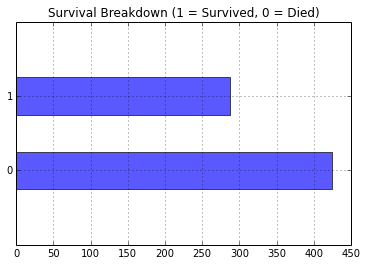

In [ ]:
plt.figure(figsize=(6,4))
fig, ax = plt.subplots()
df.Survived.value_counts().plot(kind='barh', color="blue", alpha=.65)
ax.set_ylim(-1, len(df.Survived.value_counts())) 
plt.title("Survival Breakdown (1 = Survived, 0 = Died)")

### Now let’s tease more structure out of the data,
### Let’s break the previous graph down by gender


(-1, 2)

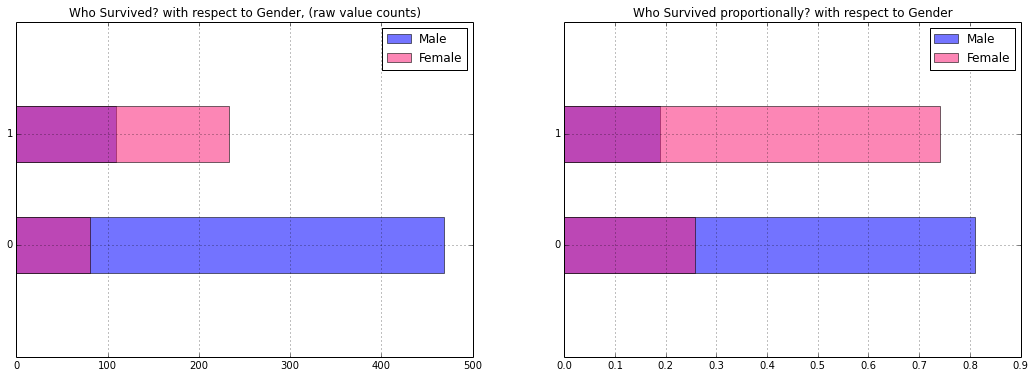

In [ ]:
fig = plt.figure(figsize=(18,6))

#create a plot of two subsets, male and female, of the survived variable.
#After we do that we call value_counts() so it can be easily plotted as a bar graph. 
#'barh' is just a horizontal bar graph
df_male = df.Survived[df.Sex == 'male'].value_counts().sort_index()
df_female = df.Survived[df.Sex == 'female'].value_counts().sort_index()

ax1 = fig.add_subplot(121)
df_male.plot(kind='barh',label='Male', alpha=0.55)
df_female.plot(kind='barh', color='#FA2379',label='Female', alpha=0.55)
plt.title("Who Survived? with respect to Gender, (raw value counts) "); plt.legend(loc='best')
ax1.set_ylim(-1, 2) 

#adjust graph to display the proportions of survival by gender
ax2 = fig.add_subplot(122)
(df_male/float(df_male.sum())).plot(kind='barh',label='Male', alpha=0.55)  
(df_female/float(df_female.sum())).plot(kind='barh', color='#FA2379',label='Female', alpha=0.55)
plt.title("Who Survived proportionally? with respect to Gender"); plt.legend(loc='best')

ax2.set_ylim(-1, 2)

Here it’s clear that although more men died and survived in raw value counts, females had a greater survival rate proportionally (~25%), than men (~20%)

#### Great! But let’s go down even further:
Can we capture more of the structure by using Pclass? Here we will bucket classes as lowest class or any of the high classes (classes 1 - 2). 3 is lowest class. Let’s break it down by Gender and what Class they were traveling in.


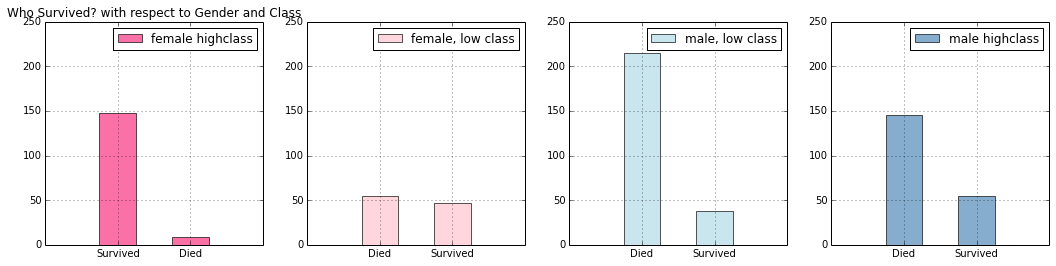

In [ ]:
fig = plt.figure(figsize=(18,4), dpi=1600)
alpha_level = 0.65

# building on the previous code, here we create an additional subset with in the gender subset 
# we created for the survived variable. I know, thats a lot of subsets. After we do that we call 
# value_counts() so it it can be easily plotted as a bar graph. this is repeated for each gender 
# class pair.
ax1=fig.add_subplot(141)
female_highclass = df.Survived[df.Sex == 'female'][df.Pclass != 3].value_counts()
female_highclass.plot(kind='bar', label='female, highclass', color='#FA2479', alpha=alpha_level)
ax1.set_xticklabels(["Survived", "Died"], rotation=0)
ax1.set_xlim(-1, len(female_highclass))
plt.title("Who Survived? with respect to Gender and Class"); plt.legend(loc='best')

ax2=fig.add_subplot(142, sharey=ax1)
female_lowclass = df.Survived[df.Sex == 'female'][df.Pclass == 3].value_counts()
female_lowclass.plot(kind='bar', label='female, low class', color='pink', alpha=alpha_level)
ax2.set_xticklabels(["Died","Survived"], rotation=0)
ax2.set_xlim(-1, len(female_lowclass))
plt.legend(loc='best')

ax3=fig.add_subplot(143, sharey=ax1)
male_lowclass = df.Survived[df.Sex == 'male'][df.Pclass == 3].value_counts()
male_lowclass.plot(kind='bar', label='male, low class',color='lightblue', alpha=alpha_level)
ax3.set_xticklabels(["Died","Survived"], rotation=0)
ax3.set_xlim(-1, len(male_lowclass))
plt.legend(loc='best')

ax4=fig.add_subplot(144, sharey=ax1)
male_highclass = df.Survived[df.Sex == 'male'][df.Pclass != 3].value_counts()
male_highclass.plot(kind='bar', label='male, highclass', alpha=alpha_level, color='steelblue')
ax4.set_xticklabels(["Died","Survived"], rotation=0)
ax4.set_xlim(-1, len(male_highclass))
plt.legend(loc='best')

Awesome! Now we have a lot more information on who survived and died in the tragedy. With this deeper understanding, we are better equipped to create better more insightful models. This is a typical process in interactive data analysis. First you start small and understand the most basic relationships and slowly increment the complexity of your analysis as you discover more and more about the data you’re working with. Below is the progression of process laid out together:

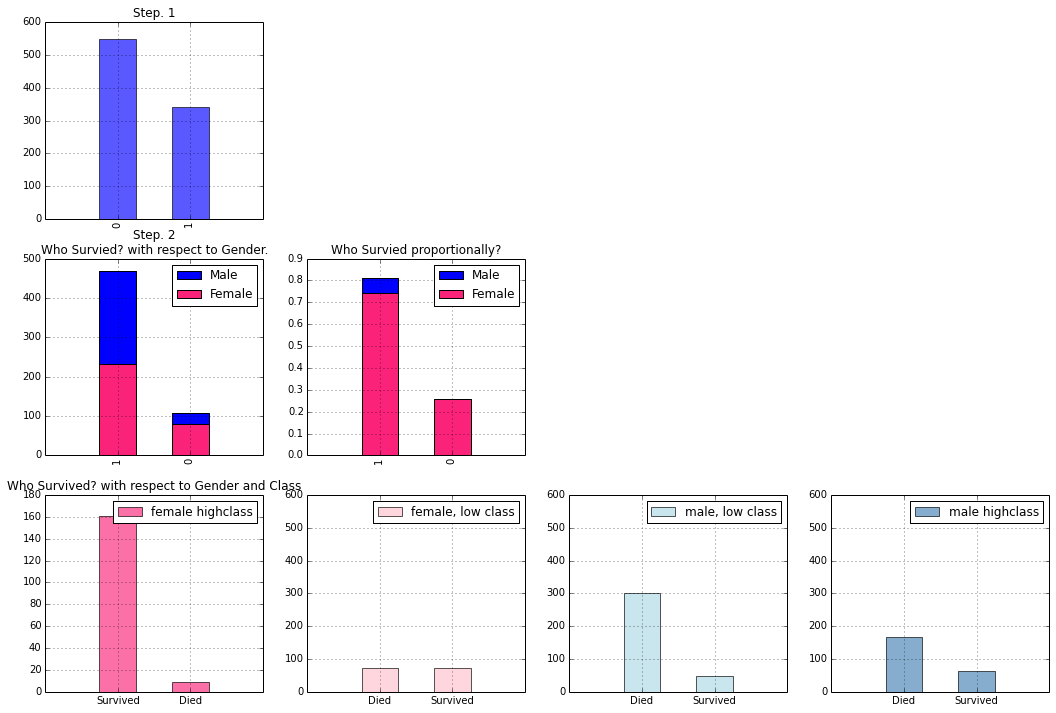

In [ ]:
fig = plt.figure(figsize=(18,12), dpi=1600)
a = 0.65
# Step 1
ax1 = fig.add_subplot(341)
df.Survived.value_counts().plot(kind='bar', color="blue", alpha=a)
ax1.set_xlim(-1, len(df.Survived.value_counts()))
plt.title("Step. 1")

# Step 2
ax2 = fig.add_subplot(345)
df.Survived[df.Sex == 'male'].value_counts().plot(kind='bar',label='Male')
df.Survived[df.Sex == 'female'].value_counts().plot(kind='bar', color='#FA2379',label='Female')
ax2.set_xlim(-1, 2)
plt.title("Step. 2 \nWho Survived? with respect to Gender."); plt.legend(loc='best')

ax3 = fig.add_subplot(346)
(df.Survived[df.Sex == 'male'].value_counts()/float(df.Sex[df.Sex == 'male'].size)).plot(kind='bar',label='Male')
(df.Survived[df.Sex == 'female'].value_counts()/float(df.Sex[df.Sex == 'female'].size)).plot(kind='bar', color='#FA2379',label='Female')
ax3.set_xlim(-1,2)
plt.title("Who Survied proportionally?"); plt.legend(loc='best')


# Step 3
ax4 = fig.add_subplot(349)
female_highclass = df.Survived[df.Sex == 'female'][df.Pclass != 3].value_counts()
female_highclass.plot(kind='bar', label='female highclass', color='#FA2479', alpha=a)
ax4.set_xticklabels(["Survived", "Died"], rotation=0)
ax4.set_xlim(-1, len(female_highclass))
plt.title("Who Survived? with respect to Gender and Class"); plt.legend(loc='best')

ax5 = fig.add_subplot(3,4,10, sharey=ax1)
female_lowclass = df.Survived[df.Sex == 'female'][df.Pclass == 3].value_counts()
female_lowclass.plot(kind='bar', label='female, low class', color='pink', alpha=a)
ax5.set_xticklabels(["Died","Survived"], rotation=0)
ax5.set_xlim(-1, len(female_lowclass))
plt.legend(loc='best')

ax6 = fig.add_subplot(3,4,11, sharey=ax1)
male_lowclass = df.Survived[df.Sex == 'male'][df.Pclass == 3].value_counts()
male_lowclass.plot(kind='bar', label='male, low class',color='lightblue', alpha=a)
ax6.set_xticklabels(["Died","Survived"], rotation=0)
ax6.set_xlim(-1, len(male_lowclass))
plt.legend(loc='best')

ax7 = fig.add_subplot(3,4,12, sharey=ax1)
male_highclass = df.Survived[df.Sex == 'male'][df.Pclass != 3].value_counts()
male_highclass.plot(kind='bar', label='male highclass', alpha=a, color='steelblue')
ax7.set_xticklabels(["Died","Survived"], rotation=0)
ax7.set_xlim(-1, len(male_highclass))
plt.legend(loc='best')

I've done my best to make the plotting code readable and intuitive, but if you’re looking for a more detailed look on how to start plotting in matplotlib, check out this beautiful notebook [here](http://nbviewer.ipython.org/github/jrjohansson/scientific-python-lectures/blob/master/Lecture-4-Matplotlib.ipynb). 

Now that we have a basic understanding of what we are trying to predict, let’s predict it.
## Supervised Machine Learning
#### Logistic Regression:

As explained by Wikipedia:
>In statistics, logistic regression or logit regression is a type of regression analysis used for predicting the outcome of a categorical dependent variable (a dependent variable that can take on a limited number of values, whose magnitudes are not meaningful but whose ordering of magnitudes may or may not be meaningful) based on one or more predictor variables. That is, it is used in estimating empirical values of the parameters in a qualitative response model. The probabilities describing the possible outcomes of a single trial are modeled, as a function of the explanatory (predictor) variables, using a logistic function. Frequently (and subsequently in this article) "logistic regression" is used to refer specifically to the problem in which the dependent variable is binary—that is, the number of available categories is two—and problems with more than two categories are referred to as multinomial logistic regression or, if the multiple categories are ordered, as ordered logistic regression.
Logistic regression measures the relationship between a categorical dependent variable and one or more independent variables, which are usually (but not necessarily) continuous, by using probability scores as the predicted values of the dependent variable.[1] As such it treats the same set of problems as does probit regression using similar techniques.

#### The skinny, as explained by yours truly:
Our competition wants us to predict a binary outcome. That is, it wants to know whether some will die, (represented as a 0), or survive, (represented as 1). A good place to start is to calculate the probability that an individual observation, or person, is likely to be a 0 or 1. That way we would know the chance that someone survives, and could start making somewhat informed predictions. If we did, we'd get results like this:: 

![pred](https://raw.github.com/agconti/kaggle-titanic/master/images/calc_prob.png) 

(*Y axis is the probability that someone survives, X axis is the passenger’s number from 1 to 891.*)

While that information is useful it doesn’t let us know whether someone ended up alive or dead. It just lets us know the chance that they will survive or die. We still need to translate these probabilities into the binary decision we’re looking for. But how? We could arbitrarily say that our survival cutoff is anyone with a probability of survival over 50%. In fact, this tactic would actually perform pretty well for our data and would allow you to make decently accurate predictions. Graphically it would look something like this:

![predwline](https://raw.github.com/agconti/kaggle-titanic/master/images/calc_prob_wline.png)

If you’re a betting man like me, you don’t like to leave everything to chance. What are the odds that setting that cutoff at 50% works? Maybe 20% or 80% would work better. Clearly we need a more exact way to make that cutoff. What can save the day? In steps the **Logistic Regression**. 

A logistic regression follows the all steps we took above but mathematically calculates the cutoff, or decision boundary (as stats nerds call it), for you. This way it can figure out the best cut off to choose, perhaps 50% or 51.84%, that most accurately represents the training data.

The three cells below show the process of creating our Logitist regression model, training it on the data, and examining its performance. 

First, we define our formula for our Logit regression. In the next cell we create a regression friendly dataframe that sets up boolean values for the categorical variables in our formula and lets our regression model know the types of inputs we're giving it. The model is then instantiated and fitted before a summary of the model's performance is printed. In the last cell we graphically compare the predictions of our model to the actual values we are trying to predict, as well as the residual errors from our model to check for any structure we may have missed.

In [ ]:
# model formula
# here the ~ sign is an = sign, and the features of our dataset
# are written as a formula to predict survived. The C() lets our 
# regression know that those variables are categorical.
# Ref: http://patsy.readthedocs.org/en/latest/formulas.html
formula = 'Survived ~ C(Pclass) + C(Sex) + Age + SibSp  + C(Embarked)' 
# create a results dictionary to hold our regression results for easy analysis later        
results = {} 

In [ ]:
# create a regression friendly dataframe using patsy's dmatrices function
y,x = dmatrices(formula, data=df, return_type='dataframe')

# instantiate our model
model = sm.Logit(y,x)

# fit our model to the training data
res = model.fit()

# save the result for outputing predictions later
results['Logit'] = [res, formula]
res.summary()

Optimization terminated successfully.
         Current function value: 0.444388
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      704
Method:                           MLE   Df Model:                            7
Date:                Sun, 20 Dec 2015   Pseudo R-squ.:                  0.3414
Time:                        11:27:33   Log-Likelihood:                -316.40
converged:                       True   LL-Null:                       -480.45
                                        LLR p-value:                 5.992e-67
====================================================================================
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept            4.5423      0.474      9.583      0.000         3.613     5.471
C(Pclass)[T.2]      -1.2673      0.299     -4.245      0.000        -1.852    -0.682
C(Pclass)[T.3]      -2.4966      0.296     -8.422      0.000        -3.078    -1.916
C(Sex)[T.male]      -2.6239      0.218    -12.060      0.000        -3.050    -2.197
C(Embarked)[T.Q]    -0.8351      0.597     -1.398      0.162        -2.006     0.335
C(Embarked)[T.S]    -0.4254      0.271     -1.572      0.116        -0.956     0.105
Age                 -0.0436      0.008     -5.264      0.000        -0.060    -0.027
SibSp               -0.3697      0.123     -3.004      0.003        -0.611    -0.129
====================================================================================
"""

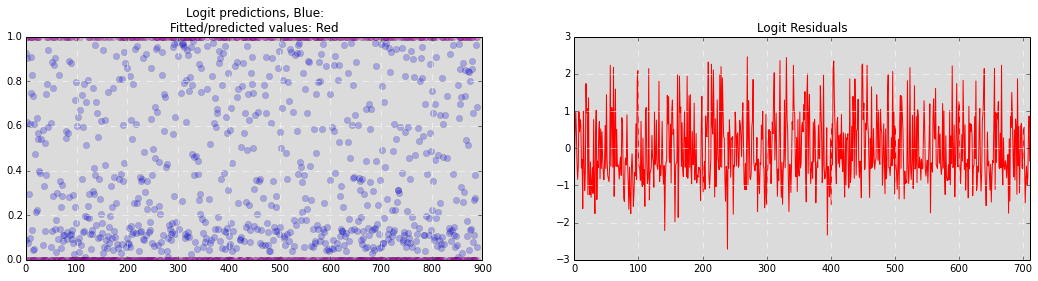

In [ ]:
# Plot Predictions Vs Actual
plt.figure(figsize=(18,4));
plt.subplot(121, axisbg="#DBDBDB")
# generate predictions from our fitted model
ypred = res.predict(x)
plt.plot(x.index, ypred, 'bo', x.index, y, 'mo', alpha=.25);
plt.grid(color='white', linestyle='dashed')
plt.title('Logit predictions, Blue: \nFitted/predicted values: Red');

# Residuals
ax2 = plt.subplot(122, axisbg="#DBDBDB")
plt.plot(res.resid_dev, 'r-')
plt.grid(color='white', linestyle='dashed')
ax2.set_xlim(-1, len(res.resid_dev))
plt.title('Logit Residuals');

## So how well did this work?
Lets look at the predictions we generated graphically:

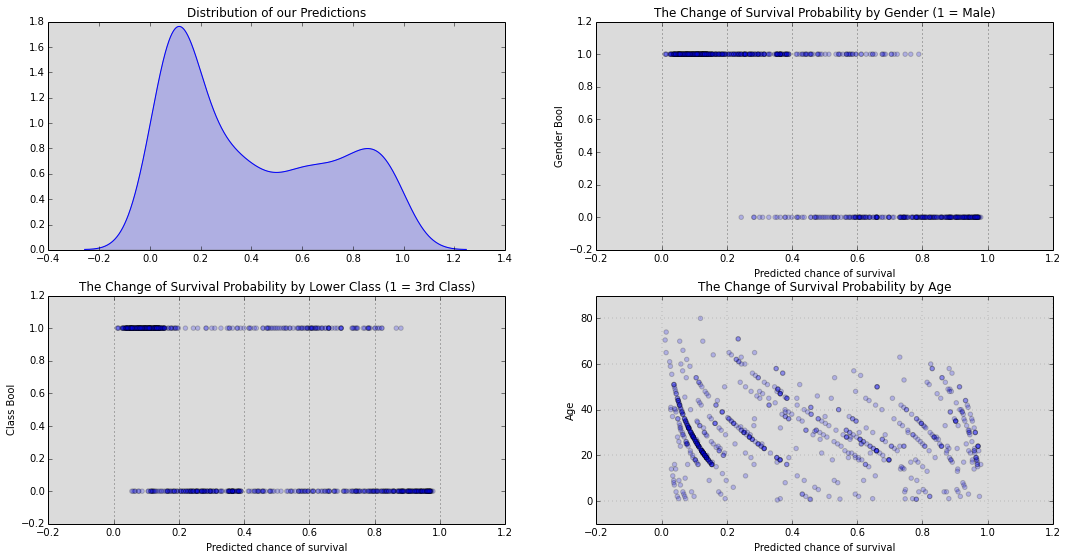

In [ ]:
fig = plt.figure(figsize=(18,9), dpi=1600)
a = .2

# Below are examples of more advanced plotting. 
# It it looks strange check out the tutorial above.
fig.add_subplot(221, axisbg="#DBDBDB")
kde_res = KDEUnivariate(res.predict())
kde_res.fit()
plt.plot(kde_res.support,kde_res.density)
plt.fill_between(kde_res.support,kde_res.density, alpha=a)
plt.title("Distribution of our Predictions")

fig.add_subplot(222, axisbg="#DBDBDB")
plt.scatter(res.predict(),x['C(Sex)[T.male]'] , alpha=a)
plt.grid(b=True, which='major', axis='x')
plt.xlabel("Predicted chance of survival")
plt.ylabel("Gender Bool")
plt.title("The Change of Survival Probability by Gender (1 = Male)")

fig.add_subplot(223, axisbg="#DBDBDB")
plt.scatter(res.predict(),x['C(Pclass)[T.3]'] , alpha=a)
plt.xlabel("Predicted chance of survival")
plt.ylabel("Class Bool")
plt.grid(b=True, which='major', axis='x')
plt.title("The Change of Survival Probability by Lower Class (1 = 3rd Class)")

fig.add_subplot(224, axisbg="#DBDBDB")
plt.scatter(res.predict(),x.Age , alpha=a)
plt.grid(True, linewidth=0.15)
plt.title("The Change of Survival Probability by Age")
plt.xlabel("Predicted chance of survival")
plt.ylabel("Age")

### Now lets use our model to predict the test set values and then save the results so they can be outputed to Kaggle
### Read the test data

In [ ]:
test_data = pd.read_csv("data/test.csv")

### Examine our dataframe

In [ ]:
test_data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


### Add our independent variable to our test data. (It is usually left blank by Kaggle because it is the value you are trying to predict.)

In [ ]:
test_data['Survived'] = 1.23

Our binned results data:

In [ ]:
results 

{'Logit': [<statsmodels.discrete.discrete_model.BinaryResultsWrapper at 0x10b1e8550>,
  'Survived ~ C(Pclass) + C(Sex) + Age + SibSp  + C(Embarked)']}

In [ ]:
# Use your model to make prediction on our test set. 
compared_resuts = ka.predict(test_data, results, 'Logit')
compared_resuts = Series(compared_resuts)  # convert our model to a series for easy output

In [ ]:
# output and submit to kaggle
compared_resuts.to_csv("data/output/logitregres.csv")

### Results as scored by Kaggle: RMSE = 0.77033  That result is pretty good. ECT ECT ECT

In [ ]:
# Create an acceptable formula for our machine learning algorithms
formula_ml = 'Survived ~ C(Pclass) + C(Sex) + Age + SibSp + Parch + C(Embarked)'

### Support Vector Machine (SVM)

*"So uhhh, what if a straight line just doesn’t cut it."*

**Wikipeda:**
>In machine learning, support vector machines (SVMs, also support vector networks[1]) are supervised learning models with associated learning algorithms that analyze data and recognize patterns, used for classification and regression analysis. The basic SVM takes a set of input data and predicts, for each given input, which of two possible classes forms the output, making it a non-probabilistic binary linear classifier. Given a set of training examples, each marked as belonging to one of two categories, an SVM training algorithm builds a model that assigns new examples into one category or the other. An SVM model is a representation of the examples as points in space, mapped so that the examples of the separate categories are divided by a clear gap that is as wide as possible. New examples are then mapped into that same space and predicted to belong to a category based on which side of the gap they fall on.
In addition to performing linear classification, SVMs can efficiently perform non-linear classification using what is called the kernel trick, implicitly mapping their inputs into high-dimensional feature spaces.

## From me
The logit model we just implemented was great in that it showed exactly where to draw our decision boundary or our 'survival cut off'.  But if you’re like me, you could have thought, "So uhhh, what if a straight line just doesn’t cut it". A linear line is okay, but can we do better? Perhaps a more complex decision boundary like a wave, circle, or maybe some sort of strange polygon would describe the variance observed in our sample better than a line.  Imagine if we were predicating survival based on age. It could be a linear decision boundary, meaning  each additional time you've gone around the sun you were 1 unit more or less likely to survive. But I think it could be easy to imagine some sort of curve, where a young healthy person would have the best chance of survival, and sadly the very old and very young a like: a poor chance. Now that’s a interesting question to answer. But our logit model can only evaluate a linear decision boundary. How do we get around this? With the usual answer to life the universe and everything;  $MATH$. 

**The answer:**
We could transform our logit equation from expressing a linear relationship like so:

$survived  = \beta_0 + \beta_1pclass + \beta_2sex + \beta_3age + \beta_4sibsp + \beta_5parch + \beta_6embarked$

Which we'll represent for convenience as: 
$y = x$
		

to a expressing a linear expression of a non-linear relationship: 
$\log(y) = \log(x)$

By doing this we're not breaking the rules. Logit models are *only* efficient at modeling linear relationships, so we're just giving it a linear relationship of a non-linear thing. 

An easy way to visualize this by looking at a graph an exponential relationship. Like the graph of $x^3$:

![x3](https://raw.github.com/agconti/kaggle-titanic/master/images/x3.png)

Here its obvious that this is not linear. If used it as an equation for our logit model, $y = x^3$; we would get bad results. But if we transformed it by taking the log  of our equation, $\log(y) = \log(x^3)$. We would get a graph like this:

![loglogx3](https://raw.github.com/agconti/kaggle-titanic/master/images/loglogx3.png)

That looks pretty linear to me. 

This process of transforming models so that they can be better expressed in a different mathematical plane is exactly what the Support Vector Machine does for us. The math behind how it does that is not trivial, so if your interested; put on your reading glasses and head over [here](http://dustwell.com/PastWork/IntroToSVM.pdf). Below is the process of implementing a SVM model and examining the results after the SVM transforms our equation into three different mathematical plains. The first is linear, and is similar to our logic model. Next is an exponential, polynomial, transformation and finally a blank transformation.


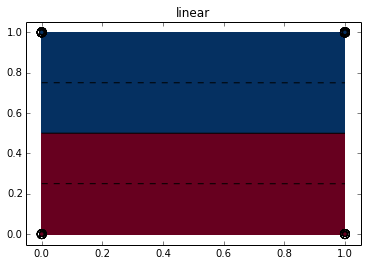

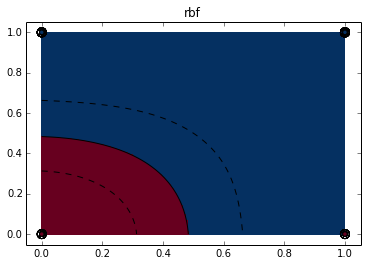

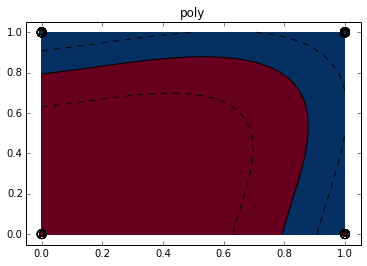

In [ ]:
# set plotting parameters
plt.figure(figsize=(8,6))

# create a regression friendly data frame
y, x = dmatrices(formula_ml, data=df, return_type='matrix')

# select which features we would like to analyze
# try chaning the selection here for diffrent output.
# Choose : [2,3] - pretty sweet DBs [3,1] --standard DBs [7,3] -very cool DBs,
# [3,6] -- very long complex dbs, could take over an hour to calculate! 
feature_1 = 2
feature_2 = 3

X = np.asarray(x)
X = X[:,[feature_1, feature_2]]  


y = np.asarray(y)
# needs to be 1 dimenstional so we flatten. it comes out of dmatirces with a shape. 
y = y.flatten()      

n_sample = len(X)

np.random.seed(0)
order = np.random.permutation(n_sample)

X = X[order]
y = y[order].astype(np.float)

# do a cross validation
nighty_precent_of_sample = int(.9 * n_sample)
X_train = X[:nighty_precent_of_sample]
y_train = y[:nighty_precent_of_sample]
X_test = X[nighty_precent_of_sample:]
y_test = y[nighty_precent_of_sample:]

# create a list of the types of kerneks we will use for your analysis
types_of_kernels = ['linear', 'rbf', 'poly']

# specify our color map for plotting the results
color_map = plt.cm.RdBu_r

# fit the model
for fig_num, kernel in enumerate(types_of_kernels):
    clf = svm.SVC(kernel=kernel, gamma=3)
    clf.fit(X_train, y_train)

    plt.figure(fig_num)
    plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=color_map)

    # circle out the test data
    plt.scatter(X_test[:, 0], X_test[:, 1], s=80, facecolors='none', zorder=10)
    
    plt.axis('tight')
    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

    # put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.pcolormesh(XX, YY, Z > 0, cmap=color_map)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
               levels=[-.5, 0, .5])

    plt.title(kernel)
    plt.show()

Any value in the blue survived while anyone in the read did not. Checkout the graph for the linear transformation. It created its decision boundary right on 50%! That guess from earlier turned out to be pretty good.  As you can see, the remaining decision boundaries are much more complex than our original linear decision boundary. These more complex boundaries may be able to capture more structure in the dataset, if that structure exists, and so might create a more powerful predictive model.

Pick a decision boundary that you like, adjust the code below, and submit the results to Kaggle to see how well it worked!

In [ ]:
# Here you can output which ever result you would like by changing the Kernel and clf.predict lines
# Change kernel here to poly, rbf or linear
# adjusting the gamma level also changes the degree to which the model is fitted
clf = svm.SVC(kernel='poly', gamma=3).fit(X_train, y_train)                                                            
y,x = dmatrices(formula_ml, data=test_data, return_type='dataframe')

# Change the interger values within x.ix[:,[6,3]].dropna() explore the relationships between other 
# features. the ints are column postions. ie. [6,3] 6th column and the third column are evaluated. 
res_svm = clf.predict(x.ix[:,[6,3]].dropna()) 

res_svm = DataFrame(res_svm,columns=['Survived'])
res_svm.to_csv("data/output/svm_poly_63_g10.csv") # saves the results for you, change the name as you please. 

### Random Forest

"Well, What if this line / decision boundary thing doesn’t work at all."

**Wikipedia, crystal clear as always:**
>Random forests are an ensemble learning method for classification (and regression) that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes output by individual trees.

**Once again, the skinny and why it matters to you:**

There are always skeptics, and you just might be one about all the fancy lines we've created so far. Well for you, here’s another option; the Random Forest. This technique is a form of non-parametric modeling that does away with all those equations we created above, and uses raw computing power and a clever statistical observation to tease the structure out of the data. 

An anecdote to explain how this the forest works starts with the lowly gumball jar. We've all guess how many gumballs are in that jar at one time or another, and odds are not a single one of us guessed exactly right. Interestingly though, while each of our individual guesses for probably were wrong, the average of all of the guesses, if there were enough, usually comes out to be pretty close to the actual number of gumballs in the jar. Crazy, I know.  This idea is that clever statistical observation that lets random forests work.

**How do they work?** A random forest algorithm randomly generates many extremely simple models to explain the variance observed in random subsections of our data.  These models are like our gumball guesses. They are all awful individually. Really awful. But once they are averaged, they can be powerful predictive tools. The averaging step is the secret sauce. While the vast majority of those models were extremely poor; they were all as bad as each other on average. So when their predictions are averaged together, the bad ones average their effect on our model out to zero. The thing that remains, *if anything*, is one or a handful of those models have stumbled upon the true structure of the data.
The cell below shows the process of instantiating and fitting a random forest, generating predictions form the resulting model, and then scoring the results.

In [ ]:
# import the machine learning library that holds the randomforest
import sklearn.ensemble as ske

# Create the random forest model and fit the model to our training data
y, x = dmatrices(formula_ml, data=df, return_type='dataframe')
# RandomForestClassifier expects a 1 demensional NumPy array, so we convert
y = np.asarray(y).ravel()
#instantiate and fit our model
results_rf = ske.RandomForestClassifier(n_estimators=100).fit(x, y)

# Score the results
score = results_rf.score(x, y)
print "Mean accuracy of Random Forest Predictions on the data was: {0}".format(score)

Mean accuracy of Random Forest Predictions on the data was: 0.945224719101


Our random forest performed only slightly better than a thumb wave, meaning that if you randomly assigned 1s and 0s by waving your thumb up and down you would do almost as well on average. It seems that this time our random forest did not stumble on the true structure of the data. 

These are just a few of the machine learning techniques that you can apply. Try a few for yourself and move up the leader board!

Ready to see more an example of a more advanced analysis? Check out these notebooks:

* [Kaggle Competition | Blue Book for Bulldozers Quantitative Model](http://nbviewer.ipython.org/github.com/agconti/AGC_BlueBook/master/BlueBook.ipynb#)
* [GOOG VS AAPL Correlation Arb](http://nbviewer.ipython.org/github.com/agconti/AGCTrading/master/GOOG%2520V.%2520AAPL%2520Correlation%2520Arb.ipynb)
* [US Dollar as a Vehicle Currency; an analysis through Italian Trade](https://github.com/agconti/US_Dollar_Vehicle_Currency)
        
#### Follow me on [github](https://github.com/agconti), and [twitter](https://twitter.com/agconti) for more books to come soon!
